In [1]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import seaborn as sns
import pickle
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import rasterio
import shapely
from scipy.optimize import minimize
from shapely.geometry import *
import time
import shutil

sys.path.insert(1, '../../modules')
# import modules
from Rouss import *
from Rouss3D import *
from ZoneBudget_ludo import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
model_dir = "working"
model_name = "test_3D"
exe_name= "../../exe/mf6"

In [3]:
# load dis infos
top,botm,idomain,delr,delc = read_pickle(os.path.join(model_dir,"export_dis3D"))

In [4]:
#spatial parameters

MNT_path = "../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
x0,y0,x1,y1 = rasterio.open(MNT_path).bounds

nlay = idomain.shape[0]
ncol = idomain.shape[2]
nrow = idomain.shape[1]

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data
ix = GridIntersect(grid)

In [5]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

In [6]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.shp"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True,layer=1)

# attribute a constant head
elev = 0.1; et_drn_lst=[];
for x in etangs_chd:
    et_drn_lst.append((x,elev,1))

In [7]:
# Prelevements agricoles
path = "../../data/prélèvements/prlvm_agri.asc"
p_agri = rspl_rast(path,grid)

# recharge
rch_path="../../data/recharge/recharge_p.tif"
rch = rspl_rast(rch_path,grid) # resample to grid
rch[rch<0]=np.mean(rch[rch>0]) # replace negative values by a mean

rch[np.abs(idomain).sum(0)==0]=0 # remove some rch
rch[idomain[0]==1]=0 # remove some rch
for cell in etangs_chd:
    rch[cell[1],cell[2]]=0
    
rch = liss_mob(rch,5)

#recharge irrigation
irr_path = "../../data/recharge/rast_irr.asc"
irr = rspl_rast(irr_path,grid)
irr[irr<0]=0

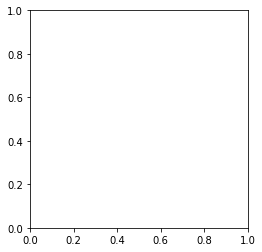

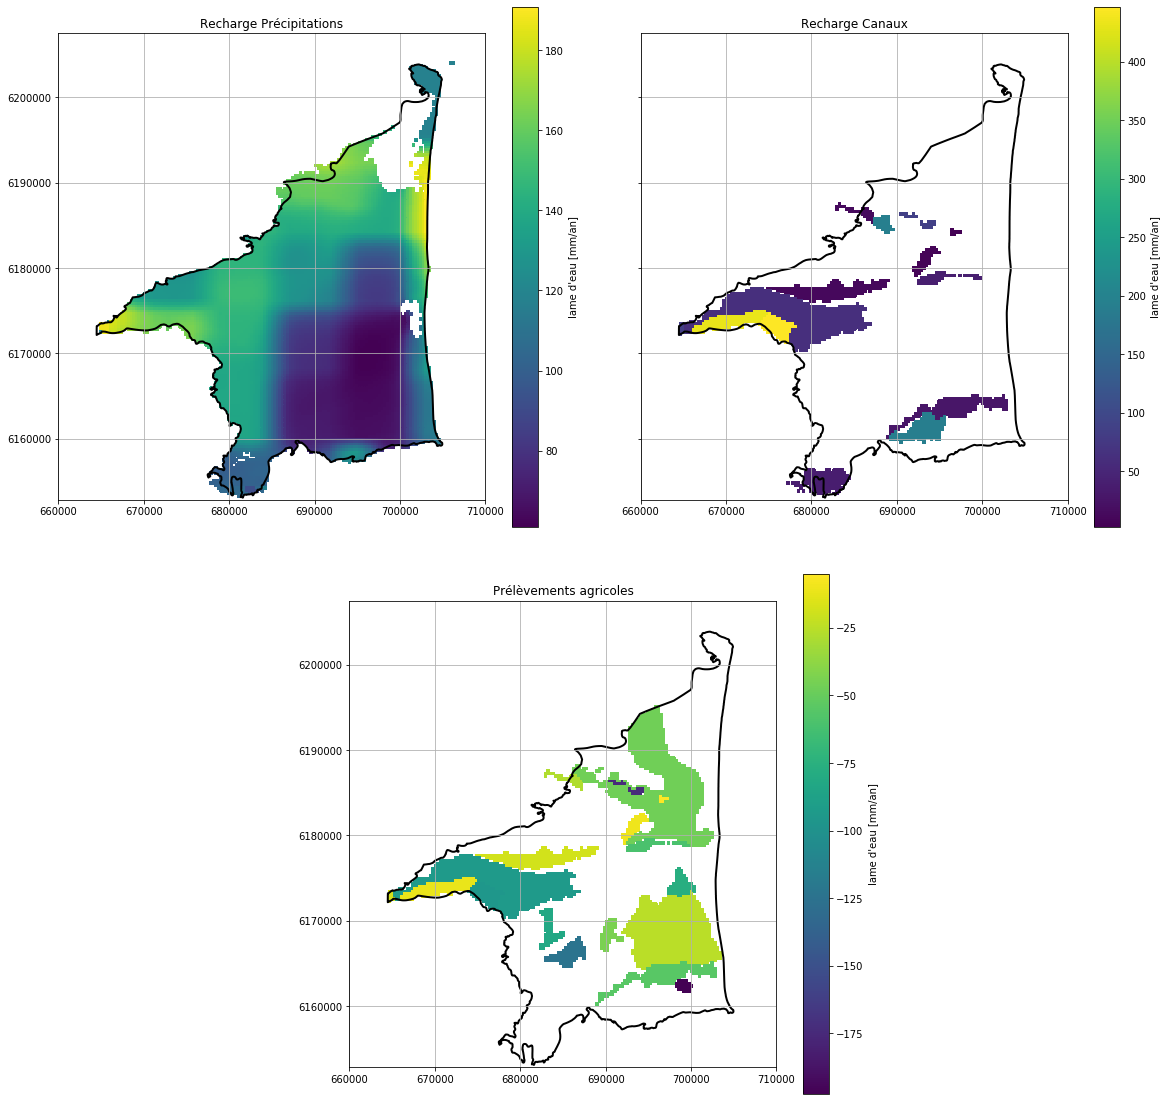

In [9]:
ml = fp.plot.PlotMapView(model=gwf)

fig = plt.figure(figsize=(20,20))
grid = plt.GridSpec(4, 4, wspace=0.2, hspace=0.2) # grid for plot
a1 = fig.add_subplot(grid[0:2,0:2])
a2 = fig.add_subplot(grid[0:2,2:4], yticklabels=[])
a3 = fig.add_subplot(grid[2:4,1:3])

axes = [a1,a2,a3]
figur = [rch,irr,p_agri]
Title = ["Recharge Précipitations","Recharge Canaux","Prélèvements agricoles"]

for i in range(3):
    a = axes[i]
    a.set_aspect("equal")
    im = figur[i]
    im[im==0]=None
    g = ml.plot_array(im,ax=a)
    a.set_xlim(660e3,710e3)
    a.grid()
    c = fig.colorbar(g,ax=a)
    c.set_label("lame d'eau [mm/an]")
    a.set(title="{}".format(Title[i]))
    fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="none",edgecolor="k",linewidth=2,ax=a)

In [10]:
np.nansum(p_agri)*0.001*300*300

-17483760.0

In [11]:
np.nansum(irr)*0.001*300*300

16808139.84375